# 13.3d: Float32→bfloat16 Monument Valley — Pairwise L∞ Distances

**Goal:** Do pairwise Chebychev distances cluster at multiples of ~6e-5 (the bfloat16 ULP)?

## The Question

If we initialize N_TOTAL_TOKENS in float32, quantize to bfloat16, then sample N_SURVIVORS:

- Do pairwise L∞ distances show **spikes** at discrete multiples of 6e-5?
- Or a **smooth** distribution?

Spikes = ice hypercube. Smooth = snow hyperball.

## Sequence

1. Initialize 151,936 tokens in float32: Gaussian(centroid, σ)
2. Convert ALL to bfloat16
3. Randomly sample 2,221 survivors
4. Compute all pairwise L∞ distances (on MPS, chunked)
5. Aggregate histogram across trials with error bars

## Parameters

In [17]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Monument Valley parameters
N_TOTAL_TOKENS = 151936
N_SURVIVORS = 2221
N_DIMS = 2560

# Sigma sweep
SIGMA_MIN = 5e-6
SIGMA_MAX = 5e-5
NUM_SAMPLES = 3  # Number of sigma values to test

# Trials per sigma
NUM_TRIALS = 10  # Repeat each sigma this many times

# Chunked computation (stay under 24GB)
CHUNK_SIZE = 300  # 300 × 2221 × 2560 × 4 bytes ≈ 6.8GB per chunk

# Histogram
HIST_MIN = 0.0
HIST_MAX = 2e-4
NUM_BINS = 100

RANDOM_SEED = 42

## Imports

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Generate Sigma Values

In [19]:
if NUM_SAMPLES == 1:
    SIGMA_VALUES = [SIGMA_MIN]
else:
    SIGMA_VALUES = np.logspace(np.log10(SIGMA_MIN), np.log10(SIGMA_MAX), NUM_SAMPLES).tolist()

print(f"\nSigma sweep: {SIGMA_MIN:.2e} to {SIGMA_MAX:.2e}")
print(f"Samples: {NUM_SAMPLES}\n")
for i, sigma in enumerate(SIGMA_VALUES):
    print(f"  [{i+1}] {sigma:.6e}")


Sigma sweep: 5.00e-06 to 5.00e-05
Samples: 3

  [1] 5.000000e-06
  [2] 1.581139e-05
  [3] 5.000000e-05


## Load Centroid

In [20]:
data = load_file(DEAD_TOKENS_PATH)
qwen_centroid = data['weighted_centroid'].to(device)

print(f"\n✓ Loaded centroid (norm = {torch.norm(qwen_centroid, p=2).item():.6f})")


✓ Loaded centroid (norm = 0.370917)


## Trial Function

In [21]:
def run_trial(sigma_f32, centroid):
    """
    Run one trial: init f32 → quantize ALL to bf16 → sample survivors → compute L∞.
    Returns array of pairwise L∞ distances (upper triangle, excluding diagonal).
    """
    # 1. Initialize in f32
    init_f32 = centroid + torch.randn(N_TOTAL_TOKENS, N_DIMS, device=device) * sigma_f32
    
    # 2. Quantize ALL to bf16
    init_bf16 = init_f32.to(torch.bfloat16)
    
    # 3. Sample survivors
    survivor_indices = torch.randperm(N_TOTAL_TOKENS, device=device)[:N_SURVIVORS]
    survivors = init_bf16[survivor_indices].to(torch.float32)  # Keep on MPS as float32
    
    # 4. Compute L∞ for all pairs (chunked on MPS)
    n = len(survivors)
    linf_distances = []
    
    for i in range(0, n, CHUNK_SIZE):
        chunk = survivors[i:i+CHUNK_SIZE]  # [chunk_size, 2560]
        diff = torch.abs(chunk.unsqueeze(1) - survivors.unsqueeze(0))  # [chunk_size, n, 2560]
        linf = torch.max(diff, dim=2)[0]  # [chunk_size, n]
        linf_distances.append(linf)
    
    linf_matrix = torch.cat(linf_distances, dim=0)  # [n, n]
    
    # Extract upper triangle (no diagonal, no duplicates)
    upper_tri_indices = torch.triu_indices(n, n, offset=1)
    pairwise_linf = linf_matrix[upper_tri_indices[0], upper_tri_indices[1]]
    
    return pairwise_linf.cpu().numpy()

print("✓ Defined trial function")

✓ Defined trial function


## Run Trials

In [22]:
print(f"\nRunning {len(SIGMA_VALUES)} sigmas × {NUM_TRIALS} trials = {len(SIGMA_VALUES) * NUM_TRIALS} total\n")

results = {}  # sigma -> list of distance arrays

for sigma in tqdm(SIGMA_VALUES, desc="Sigma sweep"):
    trial_results = []
    
    for trial_idx in tqdm(range(NUM_TRIALS), desc=f"σ={sigma:.1e}", leave=False):
        distances = run_trial(sigma_f32=sigma, centroid=qwen_centroid)
        trial_results.append(distances)
    
    results[sigma] = trial_results

print("\n✓ Trials complete")


Running 3 sigmas × 10 trials = 30 total



Sigma sweep: 100%|██████████| 3/3 [01:12<00:00, 24.01s/it]


✓ Trials complete


## Histogram with Error Bars

For each sigma, we'll compute a histogram for each trial, then plot the **mean count per bin** with **standard error bars**.

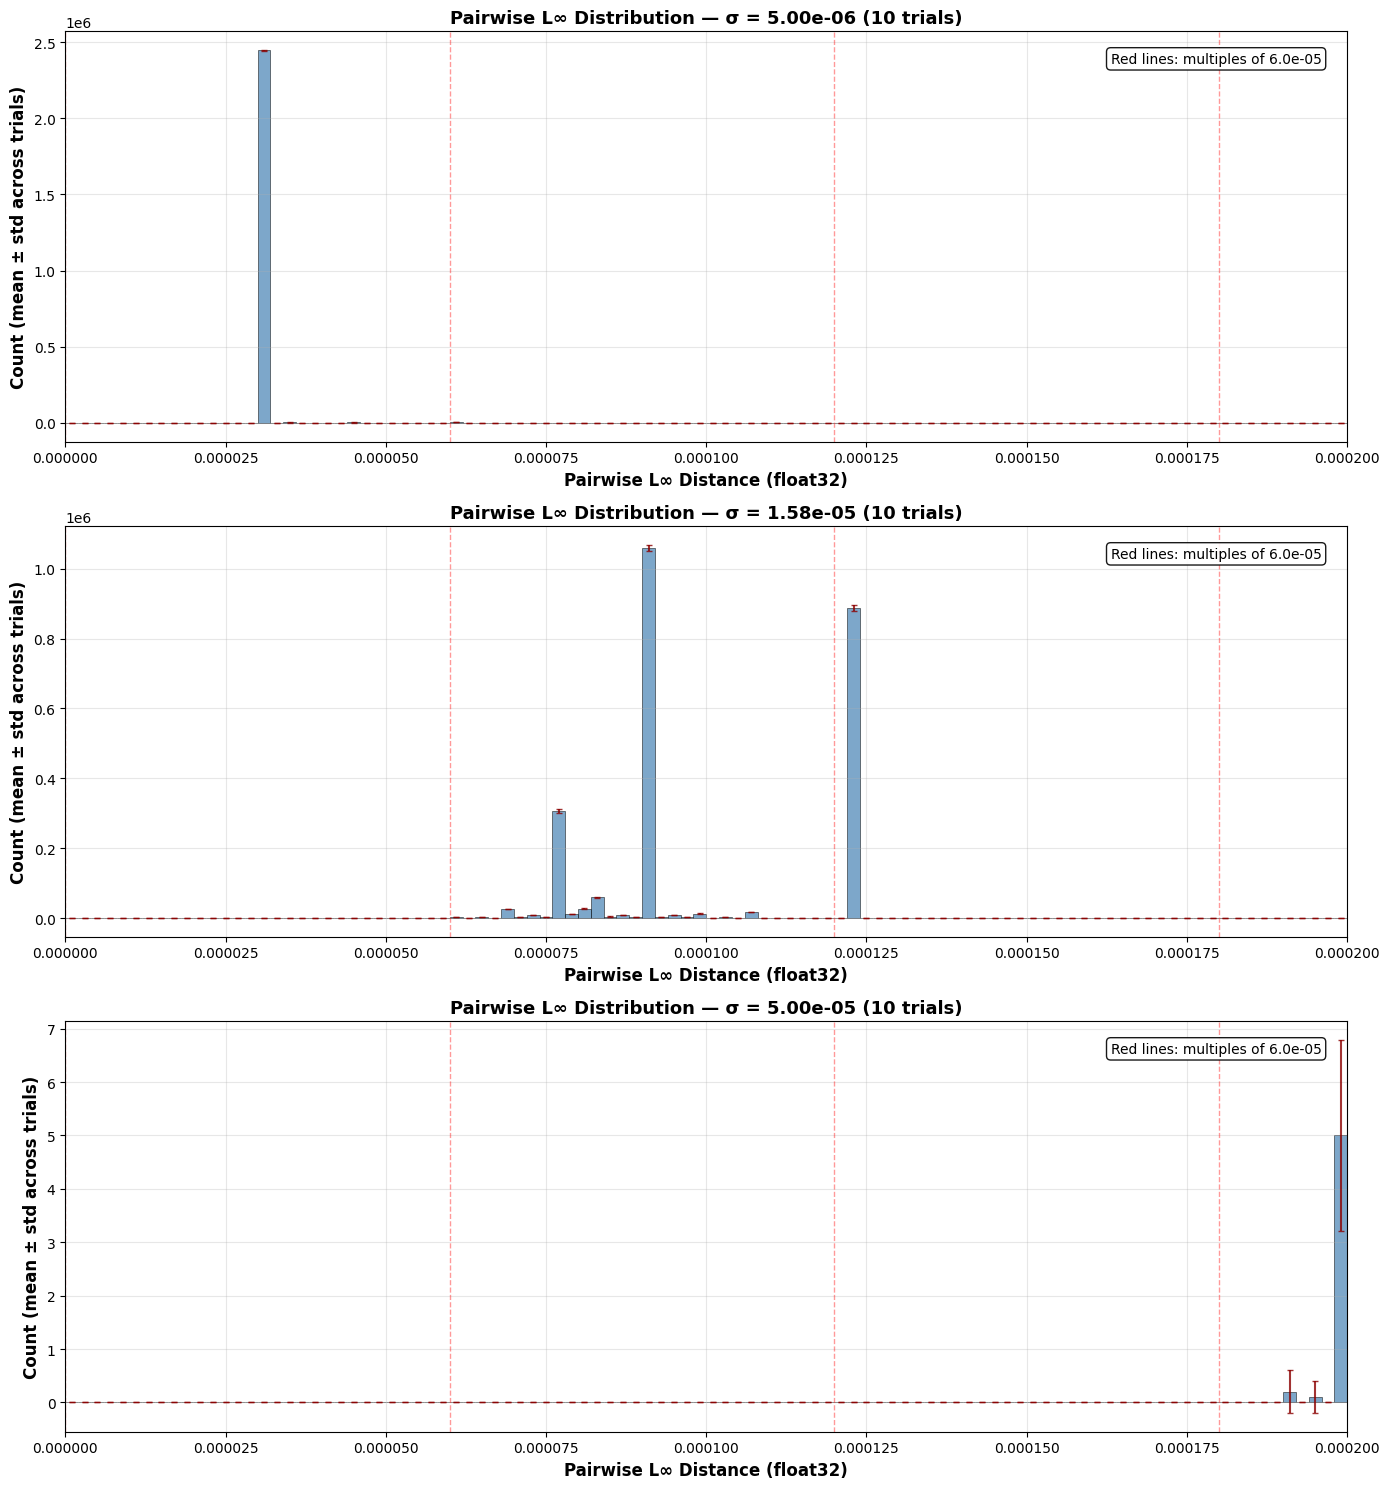


✓ Histogram complete

Red dashed lines mark multiples of 6.0e-05 (approximate bfloat16 ULP at centroid scale).
Spikes at these positions → ice hypercube.
Smooth distribution → snow hyperball.


In [23]:
bin_edges = np.linspace(HIST_MIN, HIST_MAX, NUM_BINS + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

fig, axes = plt.subplots(len(SIGMA_VALUES), 1, figsize=(14, 5*len(SIGMA_VALUES)), dpi=100)
if len(SIGMA_VALUES) == 1:
    axes = [axes]

for idx, sigma in enumerate(SIGMA_VALUES):
    ax = axes[idx]
    
    # Compute histogram for each trial
    trial_histograms = []
    for distances in results[sigma]:
        counts, _ = np.histogram(distances, bins=bin_edges)
        trial_histograms.append(counts)
    
    trial_histograms = np.array(trial_histograms)  # [NUM_TRIALS, NUM_BINS]
    
    # Mean and std across trials
    mean_counts = trial_histograms.mean(axis=0)
    std_counts = trial_histograms.std(axis=0)
    
    # Plot with error bars
    ax.bar(bin_centers, mean_counts, width=(bin_edges[1] - bin_edges[0]), 
           color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.errorbar(bin_centers, mean_counts, yerr=std_counts, fmt='none', 
                ecolor='darkred', elinewidth=1.5, capsize=2, alpha=0.8)
    
    # Mark multiples of 6e-5 with vertical lines
    ulp = 6e-5
    for mult in range(0, int(HIST_MAX / ulp) + 1):
        ax.axvline(mult * ulp, color='red', linestyle='--', alpha=0.4, linewidth=1)
    
    ax.set_xlabel('Pairwise L∞ Distance (float32)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count (mean ± std across trials)', fontsize=12, fontweight='bold')
    ax.set_title(f'Pairwise L∞ Distribution — σ = {sigma:.2e} ({NUM_TRIALS} trials)', 
                 fontsize=13, fontweight='bold')
    ax.set_xlim(HIST_MIN, HIST_MAX)
    ax.grid(True, alpha=0.3)
    
    # Legend
    ax.text(0.98, 0.95, f'Red lines: multiples of {ulp:.1e}', 
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
            fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Histogram complete")
print(f"\nRed dashed lines mark multiples of {6e-5:.1e} (approximate bfloat16 ULP at centroid scale).")
print("Spikes at these positions → ice hypercube.")
print("Smooth distribution → snow hyperball.")

## Interpretation

**Sharp spikes at 0, 6e-5, 1.2e-4, 1.8e-4:**
- Ice hypercube ✓
- Vectors occupy discrete lattice positions determined by bfloat16 quantization

**Smooth distribution:**
- Snow hyperball
- Vectors cluster but don't align to lattice

**Mixed:**
- Some dimensions quantized, others continuous

In [ ]:
# STRIPE HUNTER: Raw Pairwise Distance Scatter
# Goal: See if distances fall on discrete horizontal stripes (quantization) or continuous smear

# Take the first trial at sigma = 5e-6
sigma_to_analyze = SIGMA_VALUES[0]  # 5e-6
distances_raw = results[sigma_to_analyze][0]  # First trial

print(f"Analyzing σ = {sigma_to_analyze:.2e}")
print(f"Number of pairwise distances: {len(distances_raw):,}")
print(f"Min distance: {distances_raw.min():.6e}")
print(f"Max distance: {distances_raw.max():.6e}")

# Create scatter plot
fig, ax = plt.subplots(figsize=(16, 6), dpi=100)

# Plot all distances
x_indices = np.arange(len(distances_raw))
ax.scatter(x_indices, distances_raw, s=0.5, alpha=0.6, color='steelblue', rasterized=True)

# Mark multiples of 6e-5 with horizontal lines
ulp = 6e-5
y_max = distances_raw.max()
for mult in range(0, int(y_max / ulp) + 2):
    ax.axhline(mult * ulp, color='red', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Pair Index', fontsize=12, fontweight='bold')
ax.set_ylabel('L∞ Distance (float32)', fontsize=12, fontweight='bold')
ax.set_title(f'Raw Pairwise L∞ Distances — σ = {sigma_to_analyze:.2e} (single trial, {len(distances_raw):,} pairs)', 
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Legend
ax.text(0.98, 0.95, f'Red lines: multiples of {ulp:.1e}\\nLooking for horizontal stripes', 
        transform=ax.transAxes, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=10)

plt.tight_layout()
plt.show()

print("\n✓ Scatter plot complete")
print("\nHorizontal stripes → ice hypercube (quantization)")
print("Continuous cloud → snow hyperball (smooth)")